# DINEOF

In [1]:
import autoroot
import numpyro
import numpyro.distributions as dist
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import numpy as np
import jax.random as jr
import xarray_einstats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import pandas as pd
import einx
from tqdm.auto import trange, tqdm

key = jr.key(123)

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)


%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data

In [2]:
ds = xr.tutorial.open_dataset("air_temperature")
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [3]:
def calculate_dt(ds: xr.Dataset) -> xr.Dataset:
    return ds.time.diff("time")

In [4]:
calculate_dt(ds).values

array([21600000000000, 21600000000000, 21600000000000, ...,
       21600000000000, 21600000000000, 21600000000000],
      dtype='timedelta64[ns]')

In [5]:
# change units
# ds = ds.sel(time=slice("2013-01-01", "2013-02-01"))
ds["air"] = ds.air - 273.15

### Rearrange Data

In [6]:
# tranpose
ds = ds.transpose("time", "lon", "lat")
data = ds.air.stack(spatial=["lon", "lat"])
data = data.transpose("spatial", "time")

In [7]:
n_space = data.spatial.shape[0]
n_time = data.time.shape[0]

## Model

In [8]:
import numpy as np
from tqdm.auto import trange


class PCA(object):

    def __init__(self, n_components):
        """
        construct principal component analysis

        Parameters
        ----------
        n_components : int
            number of components
        """
        assert isinstance(n_components, int)
        self.n_components = n_components

    def fit(self, X, method="eigen", iter_max=100):
        """
        maximum likelihood estimate of pca parameters
        x ~ \int_z N(x|Wz+mu,sigma^2)N(z|0,I)dz

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data
        method : str
            method to estimate the parameters
            ["eigen", "em"]
        iter_max : int
            maximum number of iterations for em algorithm

        Attributes
        ----------
        mean : (n_features,) ndarray
            sample mean of the data
        W : (n_features, n_components) ndarray
            projection matrix
        var : float
            variance of observation noise
        C : (n_features, n_features) ndarray
            variance of the marginal dist N(x|mean,C)
        Cinv : (n_features, n_features) ndarray
            precision of the marginal dist N(x|mean, C)
        """
        method_list = ["eigen", "em"]
        if method not in method_list:
            print("availabel methods are {}".format(method_list))
        self.mean = np.mean(X, axis=0)
        getattr(self, method)(X - self.mean, iter_max)

    def eigen(self, X, *arg):
        sample_size, n_features = X.shape
        if sample_size >= n_features:
            cov = np.cov(X, rowvar=False)
            values, vectors = np.linalg.eigh(cov)
            index = n_features - self.n_components
        else:
            cov = np.cov(X)
            values, vectors = np.linalg.eigh(cov)
            vectors = (X.T @ vectors) / np.sqrt(sample_size * values)
            index = sample_size - self.n_components
        self.I = np.eye(self.n_components)
        if index == 0:
            self.var = 0
        else:
            self.var = np.mean(values[:index])

        self.W = vectors[:, index:].dot(np.sqrt(np.diag(values[index:]) - self.var * self.I))
        self.__M = self.W.T @ self.W + self.var * self.I
        self.C = self.W @ self.W.T + self.var * np.eye(n_features)
        if index == 0:
            self.Cinv = np.linalg.inv(self.C)
        else:
            self.Cinv = np.eye(n_features) / np.sqrt(self.var) - self.W @ np.linalg.inv(self.__M) @ self.W.T / self.var

    def em(self, X, iter_max):
        self.I = np.eye(self.n_components)
        self.W = np.eye(np.size(X, 1), self.n_components)
        self.var = 1.
        pbar = trange(iter_max)
        for i in pbar:
            W = np.copy(self.W)
            stats = self._expectation(X)
            self._maximization(X, *stats)
            if np.allclose(W, self.W):
                break
        self.C = self.W @ self.W.T + self.var * np.eye(np.size(X, 1))
        self.Cinv = np.linalg.inv(self.C)

    def _expectation(self, X):
        self.__M = self.W.T @ self.W + self.var * self.I
        Minv = np.linalg.inv(self.__M)
        Ez = X @ self.W @ Minv
        Ezz = self.var * Minv + Ez[:, :, None] * Ez[:, None, :]
        return Ez, Ezz

    def _maximization(self, X, Ez, Ezz):
        self.W = X.T @ Ez @ np.linalg.inv(np.sum(Ezz, axis=0))
        self.var = np.mean(
            np.mean(X ** 2, axis=1)
            - 2 * np.mean(Ez @ self.W.T * X, axis=1)
            + np.trace((Ezz @ self.W.T @ self.W).T) / np.size(X, 1))

    def transform(self, X):
        """
        project input data into latent space
        p(Z|X) = N(Z|(X-mu)WMinv, sigma^-2M)

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data

        Returns
        -------
        Z : (sample_size, n_components) ndarray
            projected input data
        """
        return np.linalg.solve(self.__M, ((X - self.mean) @ self.W).T).T

    def fit_transform(self, X, method="eigen"):
        """
        perform pca and whiten the input data

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data

        Returns
        -------
        Z : (sample_size, n_components) ndarray
            projected input data
        """
        self.fit(X, method)
        return self.transform(X)

    def proba(self, X):
        """
        the marginal distribution of the observed variable

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data

        Returns
        -------
        p : (sample_size,) ndarray
            value of the marginal distribution
        """
        d = X - self.mean
        return (
            np.exp(-0.5 * np.sum(d @ self.Cinv * d, axis=-1))
            / np.sqrt(np.linalg.det(self.C))
            / np.power(2 * np.pi, 0.5 * np.size(X, 1)))

import numpy as np


class BayesianPCA(PCA):

    def fit(self, X, iter_max=100, initial="random"):
        """
        empirical bayes estimation of pca parameters

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data
        iter_max : int
            maximum number of em steps

        Returns
        -------
        mean : (n_features,) ndarray
            sample mean fo the input data
        W : (n_features, n_components) ndarray
            projection matrix
        var : float
            variance of observation noise
        """
        initial_list = ["random", "eigen"]
        self.mean = np.mean(X, axis=0)
        self.I = np.eye(self.n_components)
        if initial not in initial_list:
            print("availabel initializations are {}".format(initial_list))
        if initial == "random":
            self.W = np.eye(np.size(X, 1), self.n_components)
            self.var = 1.
        elif initial == "eigen":
            self.eigen(X)
        self.alpha = len(self.mean) / np.sum(self.W ** 2, axis=0).clip(min=1e-10)
        for i in trange(iter_max):
            W = np.copy(self.W)
            stats = self._expectation(X - self.mean)
            self._maximization(X - self.mean, *stats)
            self.alpha = len(self.mean) / np.sum(self.W ** 2, axis=0).clip(min=1e-10)
            if np.allclose(W, self.W):
                break
        self.n_iter = i + 1

    def _maximization(self, X, Ez, Ezz):
        self.W = X.T @ Ez @ np.linalg.inv(np.sum(Ezz, axis=0) + self.var * np.diag(self.alpha))
        self.var = np.mean(
            np.mean(X ** 2, axis=-1)
            - 2 * np.mean(Ez @ self.W.T * X, axis=-1)
            + np.trace((Ezz @ self.W.T @ self.W).T) / len(self.mean))

    def maximize(self, D, Ez, Ezz):
        self.W = D.T.dot(Ez).dot(np.linalg.inv(np.sum(Ezz, axis=0) + self.var * np.diag(self.alpha)))
        self.var = np.mean(
            np.mean(D ** 2, axis=-1)
            - 2 * np.mean(Ez.dot(self.W.T) * D, axis=-1)
            + np.trace(Ezz.dot(self.W.T).dot(self.W).T) / self.ndim)

In [37]:
pca_model = PCA(n_components=50)
pca_model.fit(data.values.copy())

Z = pca_model.transform(data.values.copy())
X_recon = einx.dot("D d, B d -> B D", pca_model.W, Z)

data["recon_pca"] = (("spatial", "time"), X_recon)

/tmp/ipykernel_82070/4251108458.py:62: RuntimeWarning: invalid value encountered in sqrt
  vectors = (X.T @ vectors) / np.sqrt(sample_size * values)


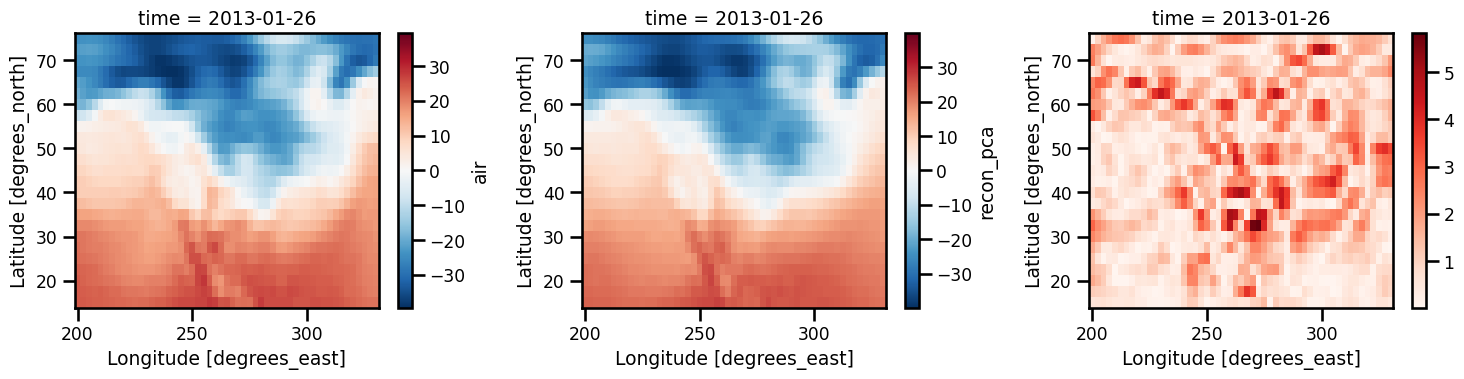

In [38]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 100

data.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
data.recon_pca.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(data - data.recon_pca).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

## PPCA

In [31]:
ppca_model = BayesianPCA(n_components=50)

In [32]:
ppca_model.fit(data.values, initial="eigen", iter_max=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [33]:
Z = ppca_model.transform(data.values.copy())

In [34]:
X_recon = einx.dot("D d, B d -> B D", ppca_model.W, Z)

In [35]:
data["recon_em"] = (("spatial", "time"), X_recon)

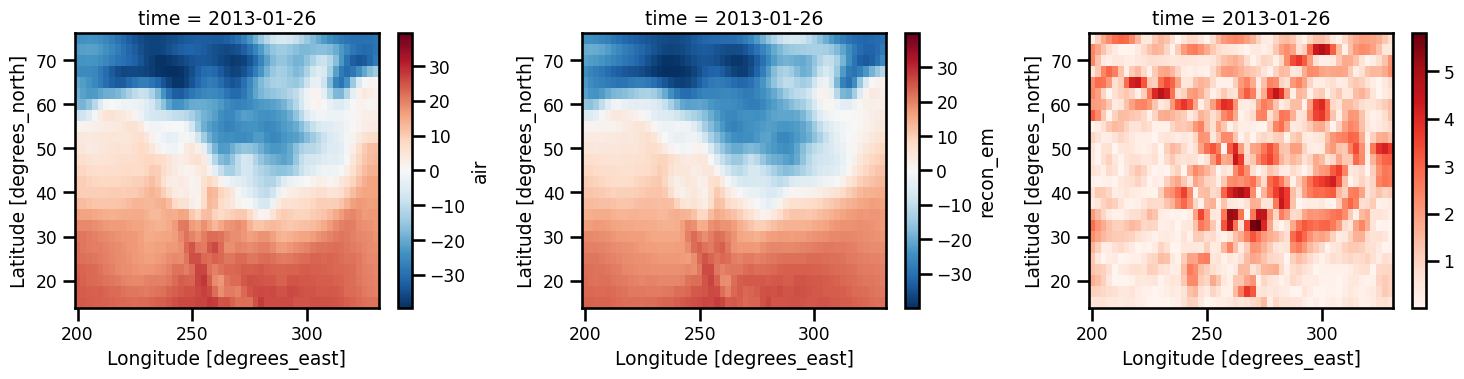

In [36]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 100

data.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
data.recon_em.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(data - data.recon_em).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

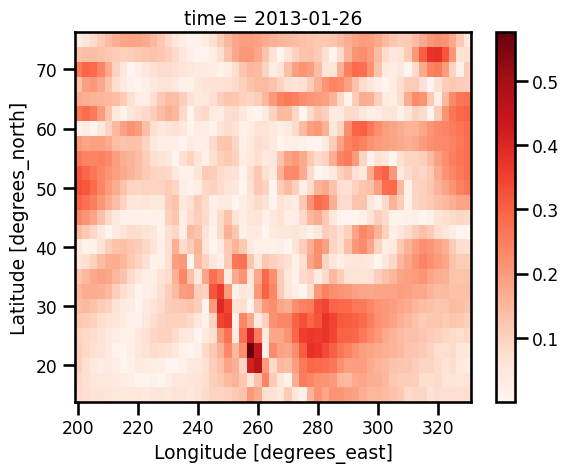

In [39]:
np.abs(data.recon_pca - data.recon_em).unstack().isel(time=itime).plot.pcolormesh(x="lon",cmap="Reds")
plt.show()

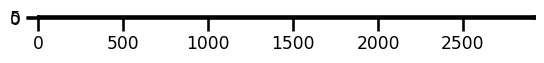

In [93]:
plt.imshow(ppca_model.W.T, origin="lower")
plt.show()

In [66]:
from typing import Optional
import equinox as eqx
from jax import Array

class PPCA(eqx.Module):

    num_features: int
    num_latent: int
    W: Array

    def __init__(self, num_features: int, num_latent: int, W: Array=None):
        self.num_features = num_features
        self.num_latent = num_latent
        self.W = jnp.ones((num_features, num_latent)) if W is None else W

    def reconstruct(self, X):
        # forward
        XW = einx.dot("D d, B D -> B d", self.W, X)
        # inversion
        inv_W = jnp.linalg.inv(self.W.T @ self.W)
        # multiple
        return self.W @ inv_W @ XW.T

In [69]:
from sklearn.decomposition import PCA

In [70]:
pca_model = PCA(n_components="mle").fit(data.values)

ValueError: n_components='mle' is only supported if n_samples >= n_features

In [ ]:
p

In [67]:

ppca_model = PPCA(n_time, 10)

In [68]:
out = ppca_model.reconstruct(data.values)

In [56]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from jaxtyping import Float, Array

In [57]:
n_space, n_time

(1325, 2920)

In [91]:
from typing import Optional
import equinox as eqx

class PPCA(eqx.Module):

    num_features: int
    num_latent: int

    def model(self, y: Float[Array, "N Dy"], batch_size: Optional[int]=None):

        # calculate alpha, prior for weights
        rate: Float[Array, "d"] = jnp.ones(shape=(self.num_latent,))
        alpha_w: Float[Array, "d"] = numpyro.sample("alpha_w", dist.Exponential(rate=rate).to_event(1))
        
        # calculate W
        loc: Float[Array, "D"] = jnp.zeros(shape=(self.num_features, self.num_latent))
        scale: Float[Array, "D D"] = einx.rearrange("d -> D d", alpha_w, D=self.num_features)
        
        W: Float[Array, "D d"] = numpyro.sample("W", dist.Normal(loc, scale).to_event(1))

        # # calculate mu
        # loc: Float[Array, "D"] = jnp.zeros(shape=(self.num_features,))
        # rate: Float[Array, "D"] = jnp.ones(shape=(self.num_features,))
        # alpha_mu: Float[Array, "D"] = numpyro.sample("alpha_mu", dist.Exponential(rate=rate).to_event(1))
        # mu: Float[Array, "D"] = numpyro.sample("mu", dist.Normal(loc, alpha_mu).to_event(1))

        # calculate scale
        sigma: Float[Array, ""] = numpyro.sample("sigma", dist.HalfCauchy(scale=1))

        # # latent variable
        loc = jnp.zeros(shape=(self.num_latent,))
        scale = jnp.ones(shape=(self.num_latent,))

        with numpyro.plate("samples", y.shape[0]):

            # batch size
            batch_y = numpyro.subsample(y, event_dim=1) if y is not None else None

            z: Float[Array, "Dz"] = numpyro.sample("z", dist.Normal(loc, scale).to_event(1))
            
            # calculate mean
            loc: Float[Array, "B D"] = einx.dot("D d, B d -> B D", W, z) 
            # loc: Float[Array, "B D"] = einx.add("B D, D -> B D", loc, mu)
            
            # calculate scale
            scale: Float[Array, "D"] = sigma * jnp.ones(shape=(self.num_features,))

            # data likelihood
            d = dist.Normal(loc=loc, scale=scale).to_event(1)
            y = numpyro.sample("y", d, obs=batch_y)

        return y

In [92]:
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer import Predictive, SVI, Trace_ELBO
import jax.random as jrandom

In [93]:
ppca_model = PPCA(num_latent=50, num_features=n_time)

In [94]:
with numpyro.handlers.seed(rng_seed=jrandom.PRNGKey(42)):
    out = ppca_model.model(y=data.values[:32])
    print(out.shape)

(32, 2920)


In [95]:
# initialize MAP guide
map_guide = AutoDelta(ppca_model.model)

# initialize svi inference
loss = Trace_ELBO()
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model=ppca_model.model, guide=map_guide, optim=optimizer, loss=loss)

num_samples: int = 1
num_steps: int = 3_000
rng_key = jrandom.PRNGKey(123)
batch_size = 128
init_params = None
svi_result = svi.run(rng_key=rng_key, init_params=init_params, num_steps=num_steps, y=data.values, batch_size=batch_size)

100%|████████████████████| 3000/3000 [02:18<00:00, 21.71it/s, init loss: 546601495.8535, avg. loss [2851-3000]: 6770751.1912]


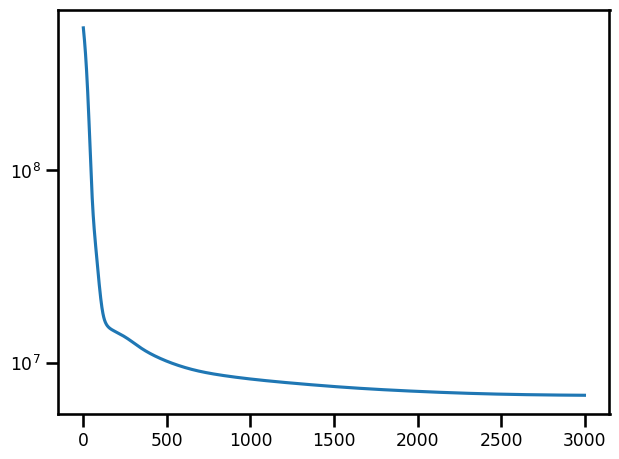

In [96]:
fig, ax = plt.subplots()
ax.plot(svi_result.losses)
ax.set(yscale="symlog")
plt.tight_layout()
plt.show()

## Inference

#### Variational Parameters

In [97]:
from numpyro.infer import Predictive

In [98]:
params = svi_result.params

In [99]:
list(params.keys())

['W_auto_loc', 'alpha_w_auto_loc', 'sigma_auto_loc', 'z_auto_loc']

In [100]:
params["W_auto_loc"].shape

(2920, 50)

#### Posterior Parameters

In [101]:
predictive = Predictive(model=ppca_model.model, guide=map_guide, params=params, num_samples=1, return_sites=["W", "z", "mu"])
predictive = Predictive(map_guide, params=params, num_samples=1, return_sites=["W", "z", "mu"])
posterior_samples = predictive(jrandom.PRNGKey(0), y=data.values)

In [102]:
posterior_samples["z"].shape

(1, 1325, 50)

In [103]:
# posterior_samples["mu"].shape, X_recon.shape

In [104]:
posterior_samples["W"].shape

(1, 2920, 50)

In [105]:
X_recon = einx.dot("B Dt Dz, B Ds Dz -> Ds Dt", posterior_samples["W"], posterior_samples["z"])
# X_recon = einx.add("Ds Dt, Dt -> Ds Dt", X_recon, posterior_samples["mu"].squeeze())
X_recon.shape

(1325, 2920)

In [106]:
# data["mean_field"] = (("time",), posterior_samples["mu"].squeeze())

In [107]:
# data.mean_field.unstack().plot()#.pcolormesh(x="time")

In [108]:
data["recon"] = (("spatial", "time"), X_recon)

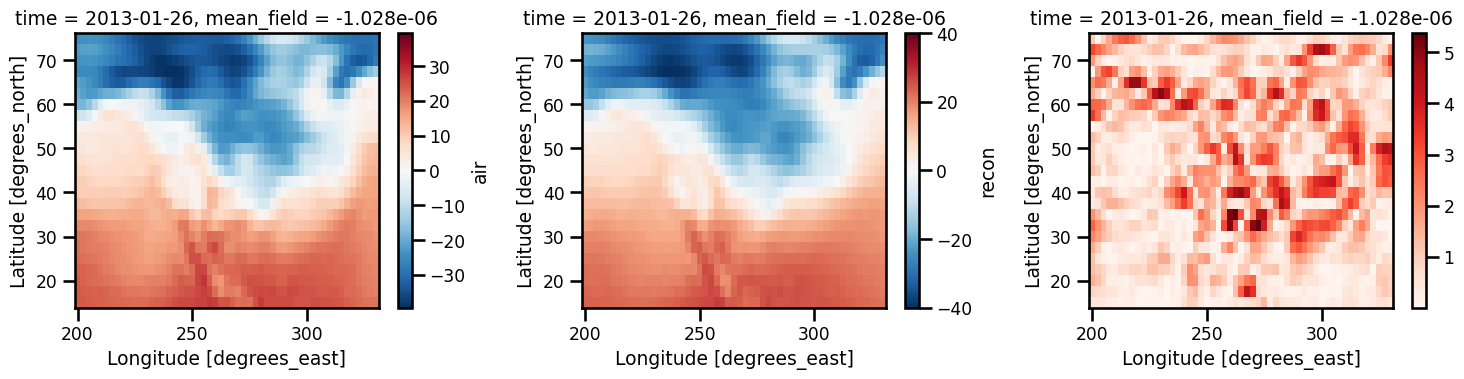

In [109]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 100

data.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
data.recon.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(data - data.recon).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()